# Automatic Extraction of Fine Structural Information in ARPES by High-order Unsupervised Clustering

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

## The study of two distinct features 

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)

### - Plot Setting

In [2]:
col_arr = ["gray","yellow","brown","blue","red"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data']  
mapdata = dataset[:]  


# Size
xn = np.shape(mapdata)[0] # x-axis  
yn = np.shape(mapdata)[1] # y-axis
en = np.shape(mapdata)[2] # Energies
an = np.shape(mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "RealData.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: RealData.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86

### - Self-defined functions for high-order unsupervised clustering

In [4]:
# Obtain the index chosen 
def get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng):
    arr = np.array(ang)
    condition = arr < ang_left
    if not np.any(condition):
        LR_col = 0
    else:
        indexes = np.where(condition)
        LR_col = indexes[0][-1]

    condition = arr > ang_right
    if not np.any(condition):
        RR_col = len(ang)-1
    else:
        indexes = np.where(condition)
        RR_col = indexes[0][0]
   
    arr = np.array(eng)
    condition = arr < eng_left
    if not np.any(condition):
        LR_row = 0
    else:
        indexes = np.where(condition)
        LR_row = indexes[0][-1]

    condition = arr > eng_right
    if not np.any(condition):
        RR_row = len(eng)-1
    else:
        indexes = np.where(condition)
        RR_row = indexes[0][0]
    
    #print("The range of angle is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(ang[LR_col],LR_col,ang[RR_col],RR_col,LR_col+1,ang[LR_col+1],RR_col-1,ang[RR_col-1]))
    #print("The range of energy is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(eng[LR_row],LR_row,eng[RR_row],RR_row,LR_row+1,eng[LR_row+1],RR_row-1,eng[RR_row-1]))
    
    return LR_col,RR_col,LR_row,RR_row

In [5]:
def get_iARPESs_of_one_cluster(clustering_result,cluster_chosen):
    arr_results = np.array(clustering_result)
    count = np.count_nonzero(arr_results == cluster_chosen-1)
    print("The number of points in cluster%d is "%cluster_chosen, count)

    x_chosen = []
    y_chosen = []
    iARPESs_chosen = np.zeros((count, en, an))

    num = 0
    for i in range(len(clustering_result)):
        curcln = clustering_result[i]  
        if curcln == cluster_chosen - 1:
            curRow = math.floor(i/yn)  # the row of positon i
            curCol = i % yn            # the column of positon i
        
            x_chosen = np.append(x_chosen, xpos[i])
            y_chosen = np.append(y_chosen, ypos[i])
        
            iARPESs_chosen[num][:][:] = mapdata[curRow][curCol][:][:].nxvalue
            num = num + 1

    return x_chosen, y_chosen, iARPESs_chosen  

In [6]:
def get_iEDCs_of_given_range(ang_left,ang_right,eng_left,eng_right,ang,eng,iARPESs_chosen):
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng)
    new_iARPESs_chosen = np.zeros((iARPESs_chosen.shape[0], RR_row-LR_row+1, RR_col-LR_col+1))
    #print("test: ",new_iARPESs_chosen.shape)
    new_iARPESs_chosen[:][:][:] = iARPESs_chosen[:,LR_row:RR_row+1,LR_col:RR_col+1]
    iEDCs_chosen = np.sum(new_iARPESs_chosen, axis = 2).reshape(new_iARPESs_chosen.shape[0], new_iARPESs_chosen.shape[1]) 
    return iEDCs_chosen 

In [7]:
def calElbow(data,max_nk):    
    sse = np.zeros(max_nk)
    xsse = np.zeros(max_nk)
    
    for i in range(max_nk):
        curnk = i + 1 
        km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
        km_model = km.fit(data)
        sse[i] = km_model.inertia_ 
        xsse[i] = curnk
        #print("xsse[i]: ",xsse[i])
        #print("sse, xsse: ",sse,xsse)
    return sse, xsse
    

In [8]:
def plot(xlist,ylist):
 
    plt.figure(figsize=(10,9))
    plt.plot(xlist, ylist, marker="o",linewidth=2)
    plt.grid(True)
    plt.xlabel('Maximum number of clusters')
    plt.ylabel('Sum of Squared Error')
    return plt

In [9]:
def get_sse_matrix(iARPESs_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk):
    englst = np.linspace(engstart, engend, engbin+1)
    anglst = np.linspace(angstart, angend, angbin+1)
    
    ssematrix = []
    print("engbin,angbin: ", engbin,angbin)
    for i in range(engbin):
        for j in range(angbin):
            angleft = anglst[j]
            angright = anglst[j+1]
            engleft = englst[i]
            engright = englst[i+1]
            iEDCs = get_iEDCs_of_given_range(angleft,angright,engleft,engright,ang,eng,iARPESs_chosen)
            ylist,xlist = calElbow(iEDCs,max_nk)
            ylist = np.divide(ylist, sum(ylist))
            ssematrix.append(ylist)
            print("engbin and angbin are: ",i,j)
        
    ssematrix = np.reshape(ssematrix,(engbin*angbin,max_nk))
    print(ssematrix)
    return ssematrix

In [10]:
def get_sse_curve(maxnk,data):
    ssehh = np.zeros(maxnk)
    xssehh = np.zeros(maxnk)

    for i in range(maxnk):
        curnk = i + 1 
        km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
        km_model = km.fit(data)
        ssehh[i] = km_model.inertia_ 
        xssehh[i] = curnk
        
    
    fig = plt.figure(figsize=(10,9))
    plt.plot(xssehh, ssehh, marker='s', color='brown',linewidth=2)
    plt.grid(True)
    plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
    plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    ax=plt.gca()
    ax.yaxis.get_offset_text().set_fontsize(fontsize1)
    
    plt.show()
    return fig


In [11]:
def get_important_field(nk, data, angstart, angend, engend, engstart,englist, anglist,label_mapping):
    kmhh = KMeans(n_clusters=nk, n_init=10, random_state=100)
    km_modelhh = kmhh.fit(data)
    km_resultshh = km_modelhh.labels_
    pnhh = len(km_resultshh) 
    if label_mapping is not None:
        label_mapping = label_mapping  
        km_resultshh = np.array([label_mapping[label] for label in km_resultshh])

    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    pn = len(km_resultshh)

    lengthx=(angend-angstart)/angbin
    widthx=(engend-engstart)/engbin
    for i in range(nk):
        for j in range(pn):
            curcln = km_resultshh[j]
            if i == curcln:
                x = anglist[j]
                y = englist[j]
                #(x, y): The coordinates of the lower-left corner of the rectangle.lengthx/width: The length/width of the rectangle.
                rect = plt.Rectangle((x, y),lengthx, widthx, linewidth=0, edgecolor="black", facecolor=col_arr[i])
                ax.add_patch(rect)

    ax.set_xlim(angend, angstart) 
    ax.set_ylim(engstart, engend)
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=col_arr[i]) for i in range(nk)]
    labels = [f'{i+1}' for i in range(nk)]
    labels.insert(0, 'Cluster:')  
    handles.insert(0, plt.Rectangle((0, 0), 1, 1, color='white'))  
    legend = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.1), ncol=nk+1)
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')

    plt.show()

    km_resultshh = np.reshape(km_resultshh,(engbin,angbin))
    return km_resultshh,fig

In [12]:
def get_ranges_of_one_filed(clustering_result, target,angstart, angend,engstart, engend,angbin,engbin):
    indices = np.where(clustering_result == target)
    rows = indices[0]
    cols = indices[1]

    englst = np.linspace(engstart, engend, engbin+1)
    anglst = np.linspace(angstart, angend, angbin+1)

    engleft = englst[rows]
    engright = englst[rows+1]
    angleft = anglst[cols]
    angright = anglst[cols+1]
    
    return engleft, engright, angleft, angright


In [13]:
def get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng):
    iARPESs_of_one_field = np.zeros((iARPESs_chosen.shape[0],iARPESs_chosen.shape[1],iARPESs_chosen.shape[2]))
    for i in range(iARPESs_chosen.shape[0]):
        for j in range(len(engleft)):
            LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angleft[j],angright[j],engleft[j],engright[j],ang,eng)
            iARPESs_of_one_field[i][LR_row:RR_row+1,LR_col:RR_col+1] = iARPESs_chosen[i][LR_row:RR_row+1,LR_col:RR_col+1]
   
    return iARPESs_of_one_field            

In [14]:
def get_iEDCs_of_one_field(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_chosen,ang,eng):
    engleft, engright, angleft, angright = get_ranges_of_one_filed(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin)
    iARPESs_of_one_field = get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng)
    
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    print(LR_col,RR_col,LR_row,RR_row)
    iARPESs_of_one_field = iARPESs_of_one_field[:,LR_row:RR_row+1,LR_col:RR_col+1]

    iEDCs_of_one_field = np.sum(iARPESs_of_one_field, axis = 2).reshape(iARPESs_of_one_field.shape[0],iARPESs_of_one_field.shape[1]) 

    fig, ax = plt.subplots()
    im = ax.imshow(iEDCs_of_one_field, extent = [engstart, engend, 1,iARPESs_of_one_field.shape[0]], aspect = 0.0025)
    cbar = fig.colorbar(im)

    plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
    plt.ylabel('Data Points',fontsize=fontsize1)
    plt.title("iEDCs",fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    cbar.ax.tick_params(labelsize=fontsize2)
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.gcf()
    plt.show()
    
    return iEDCs_of_one_field,iARPESs_of_one_field

In [15]:
def clustering_and_visualization(nk,data,x_chosen,y_chosen,label_mapping):
    km = KMeans(n_clusters=nk, n_init=10, random_state=100)
    km_model = km.fit(data)
    km_results_chosen = km_model.labels_
    pn_chosen = len(km_results_chosen) 
    if label_mapping is not None:
        label_mapping = label_mapping
        km_results_chosen = np.array([label_mapping[label] for label in km_results_chosen])
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(nk):
        x = []
        y = []
        for j in range(len(km_results_chosen)):
            curcln = km_results_chosen[j]
            if i == curcln:
                x = np.append(x, x_chosen[j])
                y = np.append(y, y_chosen[j])
            if j == pn_chosen-1:
                ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i],label=str(i+1))
    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1)  
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    blank_handle = plt.Line2D([], [], color='none', label='Clusters: ')
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, blank_handle)
    labels.insert(0, 'Clusters: ')
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
    plt.show()
    
    return km_results_chosen,fig

In [16]:
def iARPESs_cluster_visualization_range(nk,clustering_result,angstart,angend,engstart,engend,ang,eng,iARPESs_chosen):
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,angend,engstart,engend,ang,eng)
    iARPESs_Range = np.zeros((nk, RR_row-LR_row+1, RR_col-LR_col+1))

    for i in range(iARPESs_chosen.shape[0]):
        curcln = clustering_result[i]  
        iARPESs_Range[curcln][:][:] += iARPESs_chosen[i][LR_row:RR_row+1,LR_col:RR_col+1]
        
    n_col = 4 # Set to adjust your screen
    n_row = math.ceil(nk/n_col)
    fig = plt.figure(figsize=(10*n_col, 9*n_row))

    for i in range(nk):
        iARPES_Range = np.zeros((RR_row-LR_row+1, RR_col-LR_col+1))
        iARPES_Range = iARPESs_Range[i]
        curax = fig.add_subplot(n_row, n_col, i+1)
        curax.set_title("Cluster"+str(i+1))
        plt.xticks(fontsize=fontsize1)
        plt.yticks(fontsize=fontsize1)
        curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
        curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
        if i==0:
            curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
        if i!=0:
            curax.set_yticks([]) 

        plt.imshow(iARPES_Range, aspect="auto", extent= [angstart, angend, engend, engstart])
    fig.tight_layout()
    plt.show()
    return fig

In [17]:
def iARPESs_cluster_visualization(nk,clustering_result,iARPESs_chosen,angstart, angend, engstart, engend):
    iARPESs_Range = np.zeros((nk,iARPESs_chosen.shape[1], iARPESs_chosen.shape[2]))

    for i in range(iARPESs_chosen.shape[0]):
        curcln = clustering_result[i]  
        iARPESs_Range[curcln][:][:] += iARPESs_chosen[i][:][:]
        
    n_col = 4 # Set to adjust your screen
    n_row = math.ceil(nk/n_col)
    fig = plt.figure(figsize=(10*n_col, 9*n_row))

    for i in range(nk):
        iARPES_Range = np.zeros((iARPESs_chosen.shape[1], iARPESs_chosen.shape[2]))
        iARPES_Range = np.flip(iARPESs_Range[i])
        curax = fig.add_subplot(n_row, n_col, i+1)
        curax.set_title("Cluster"+str(i+1))
        plt.xticks(fontsize=fontsize1)
        plt.yticks(fontsize=fontsize1)
        curax.set_title("Cluster"+str(i+1), fontsize=fontsize1)
        curax.set_xlabel('Detector Angle (deg)', fontsize=fontsize1)
        if i==0:
            curax.set_ylabel('Kinetic Energy (eV)', fontsize=fontsize1)
        if i!=0:
            curax.set_yticks([]) 
        plt.imshow(iARPES_Range, aspect="auto", extent= [angend, angstart, engstart, engend])
    fig.tight_layout()
    plt.show()
    return fig

In [18]:
# The input is the traditional K-Means clustering result(the labels), the label which you want to analyse(cluster_number),the area in momentum space you want to analyse, the number of intervals in energy and angle directions, the number of values SSE curve includes
# The output is the positions(x,y) and ARPES images of the scan points belonging to the chosen label, and the clutering results(SSE curve) of all intervals
def get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(clustering_results,cluster_number,energy_start, energy_end,angle_start, angle_end,energy_bin,angle_bin,nk_scan):
    x_chosen, y_chosen, iARPESs_chosen = get_iARPESs_of_one_cluster(clustering_results,cluster_number)
    ssematrix = get_sse_matrix(iARPESs_chosen,energy_start, energy_end,angle_start, angle_end,energy_bin,angle_bin,nk_scan)
    #fig = get_sse_curve(nk_scan,ssematrix)
    
    return x_chosen, y_chosen, iARPESs_chosen,ssematrix

### - Choose the dataset for high-order clustering and setup the intervals(1600 cells case)

In [19]:
# perform high-order unsupervised clustering based on the above K-means clustering of nk=3 case
coarseclustering_chosen = 3
fineclusteringfile = f'kmresults_{coarseclustering_chosen}.npy'
if not os.path.exists(fineclusteringfile):
    print(f"File {fineclusteringfile} does not exist")
else:
    print(f"File {fineclusteringfile} exist")   
results = np.load(fineclusteringfile)

# perform high-order unsupervised clustering based ARPES images of cluster 2 (MoS2)
cluster_chosen = 2
# Analysis range from Ek 92 to 96eV and angle -15 to 5deg.
engstart = 92
engend = 96
angstart = -15
angend = 5
# divide the analysis range into 1600 cells (40 intervals in Ek direction and 40 intervals in angle direction)
engbin = 40
angbin = 40

# Get the minimum value of energy and angle of each interval
k=0
englist=np.zeros(engbin*angbin)
anglist=np.zeros(engbin*angbin)
for i in range(engbin):
    for j in range(angbin):
        anglist[k] = angstart+(angend-angstart)/angbin*j
        englist[k] = engstart+(engend-engstart)/engbin*i
        k += 1
#print(englist)
#print(anglist)

# SSE curve includes 10 SSE values
max_nk = 10

folder = f'results_fineclustering_{coarseclustering_chosen}'
if not os.path.exists(folder):
    print(f"{folder} does not exist")
    os.makedirs(folder)
    
plotfolder = f'{folder}/plot_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}'
if not os.path.exists(plotfolder):
    print(f"{plotfolder} does not exist")
    os.makedirs(plotfolder)

File kmresults_3.npy exist


### - Complete the Traditional K-Means clustering for all intervals

In [20]:
t1 = time.time() 

xfile = f'{folder}/x_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
yfile = f'{folder}/y_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
iARPESsfile = f'{folder}/iARPESs_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'
ssefile = f'{folder}/ssematrix_cluster{cluster_chosen}_eng{engstart}_{engend}_ang{angstart}_{angend}_engbin{engbin}_angbin{angbin}.npy'

file_paths = [xfile, yfile, iARPESsfile, ssefile]  

all_files_exist = True

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist")
        all_files_exist = False

if all_files_exist:
    print("All Files exist")
else:
    print("Some files do not exist, execute the following command")
    # Get the position in real space(x,y), ARPES images of cluster 2(cluster_chosen) based on the traditional K-means result(result)
    # Get the clustering result(SSE curve) based on the area(engstart, engend,angstart, angend) and intervals(engbin,angbin)
    x_cluster, y_cluster, iARPESs_cluster,ssematrix_cluster = get_realspace_location_and_iARPESs_and_ssematrix_of_one_cluster(results,cluster_chosen,engstart, engend,angstart, angend,engbin,angbin,max_nk)
    np.save(xfile, x_cluster)
    np.save(yfile, y_cluster)
    np.save(iARPESsfile, iARPESs_cluster)
    np.save(ssefile, ssematrix_cluster)

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

All Files exist
Elapsed Time:  0.0


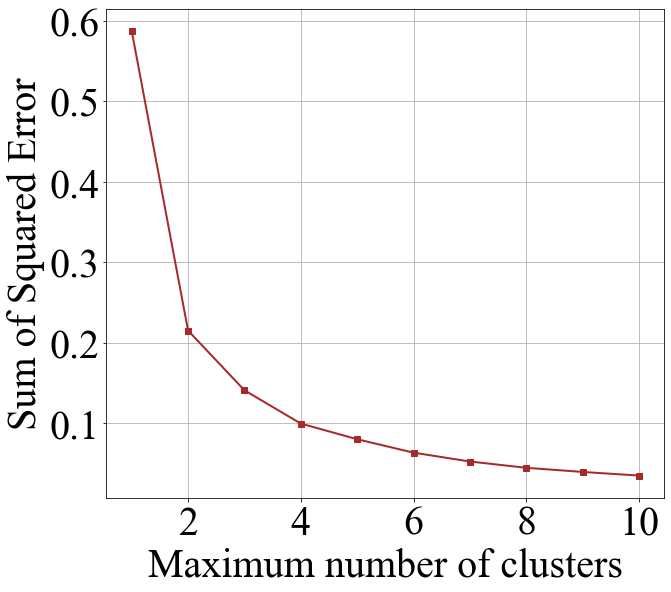

In [21]:
x_cluster = np.load(xfile)
y_cluster = np.load(yfile)
iARPESs_cluster = np.load(iARPESsfile)
ssematrix_cluster = np.load(ssefile)
fig = get_sse_curve(max_nk,ssematrix_cluster)
fig.savefig(f'{plotfolder}/SSEplot.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSEplot.png', dpi=300, bbox_inches='tight')

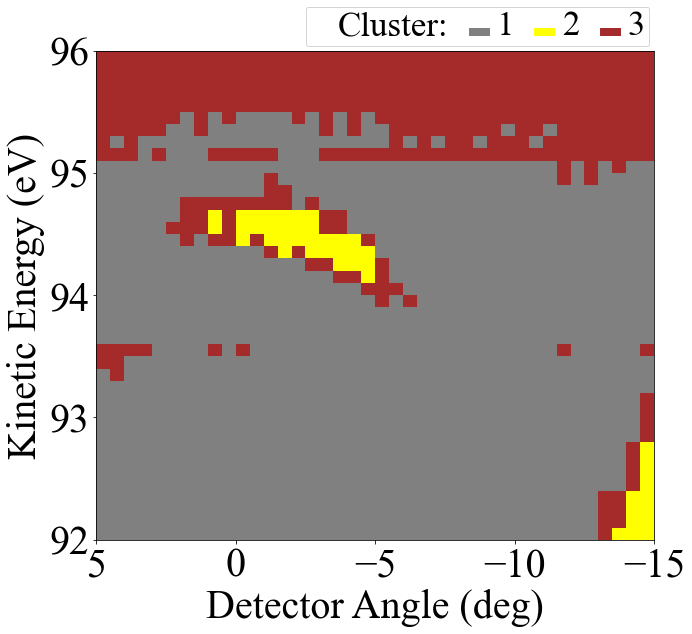

In [22]:
nk = 3
clresult_cluster,fig = get_important_field(nk, ssematrix_cluster,angstart, angend, engend, engstart,englist, anglist,label_mapping = {1:0,0:1,2:2})
fig.savefig(f'{plotfolder}/field_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/field_3.png', dpi=300, bbox_inches='tight')

5 30 417 656


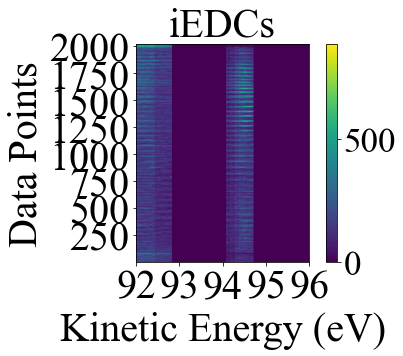

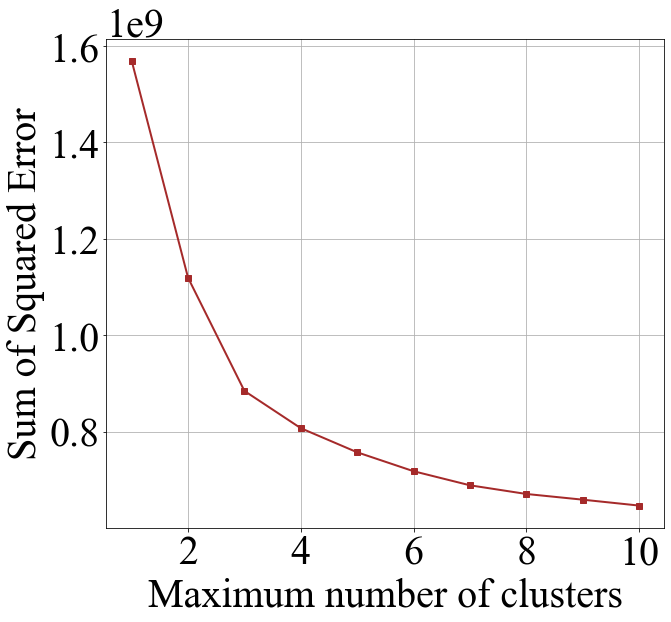

In [23]:
target = 1

iEDCs_of_target_cluster, iARPESs_of_target_cluster = get_iEDCs_of_one_field(clresult_cluster, target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_cluster,ang,eng)
fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3.png', dpi=300, bbox_inches='tight')

### - Analyse the feature(top valence band)

In [24]:
def get_iEDCs_of_one_field(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_chosen,ang,eng):
    engleft, engright, angleft, angright = get_ranges_of_one_filed(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin)
    iARPESs_of_one_field = get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng)
    
    # The range in angle direction is from angstart to -10 deg
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(angstart,-10,engstart,engend,ang,eng)
    print(LR_col,RR_col,LR_row,RR_row)
    iARPESs_of_one_field = iARPESs_of_one_field[:,LR_row:RR_row+1,LR_col:RR_col+1]

    iEDCs_of_one_field = np.sum(iARPESs_of_one_field, axis = 2).reshape(iARPESs_of_one_field.shape[0],iARPESs_of_one_field.shape[1]) 
    
    fig = plt.figure(figsize=(10,9))
    plt.rcParams['font.family'] = 'Times New Roman'
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(iEDCs_of_one_field, extent = [engstart, engend, 1,iARPESs_of_one_field.shape[0]], aspect = 0.0025)
    cbar = fig.colorbar(im)

    plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
    plt.ylabel('Data Points',fontsize=fontsize1)
    plt.title("iEDCs",fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    cbar.ax.tick_params(labelsize=fontsize2)
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.gcf()
    plt.show()
    
    return iEDCs_of_one_field,iARPESs_of_one_field

5 12 417 656


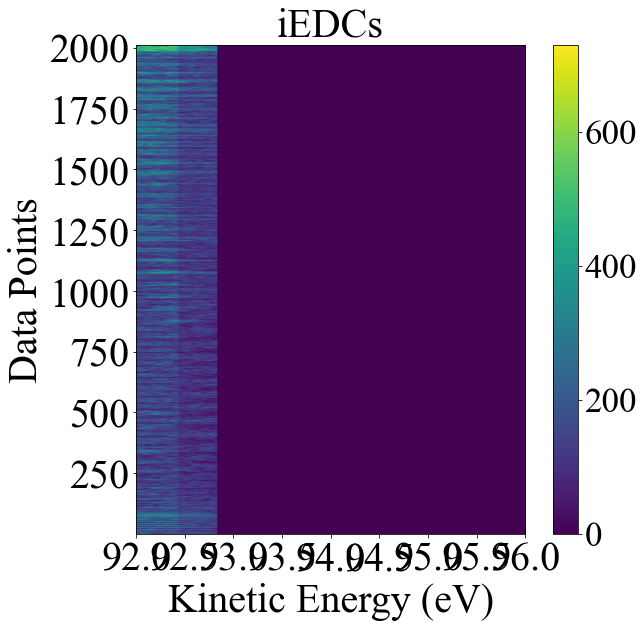

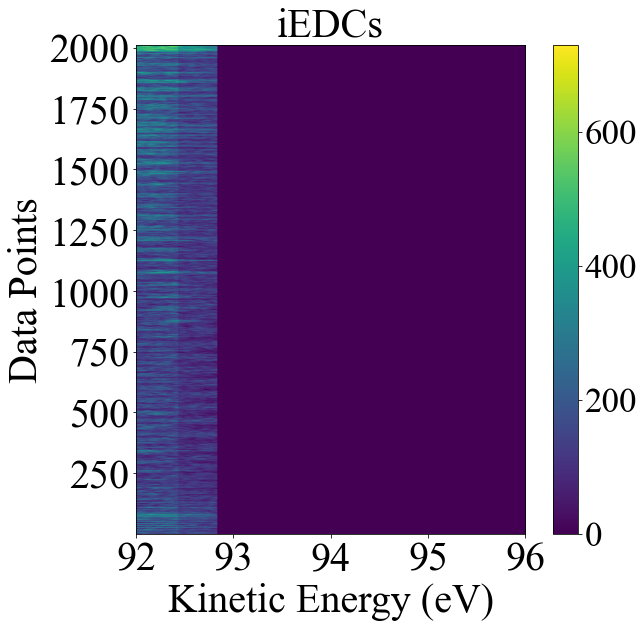

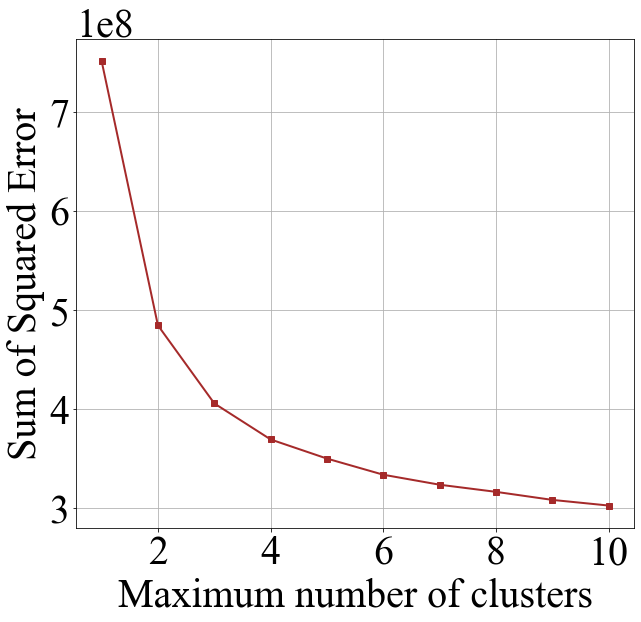

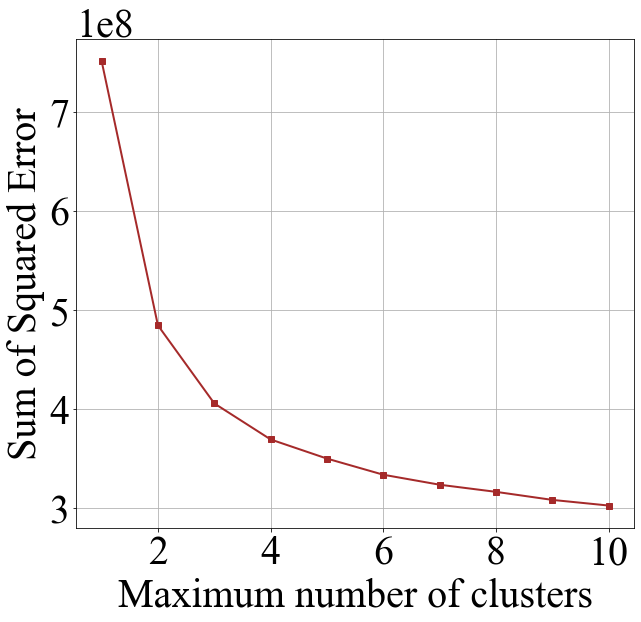

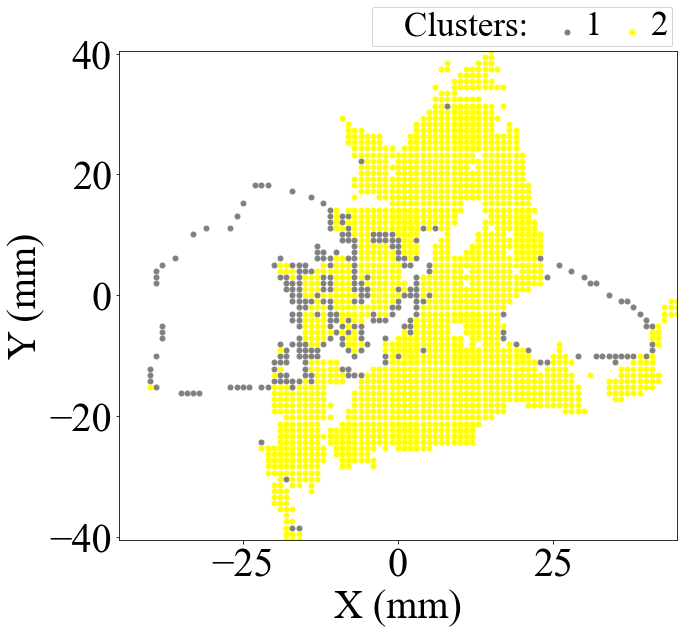

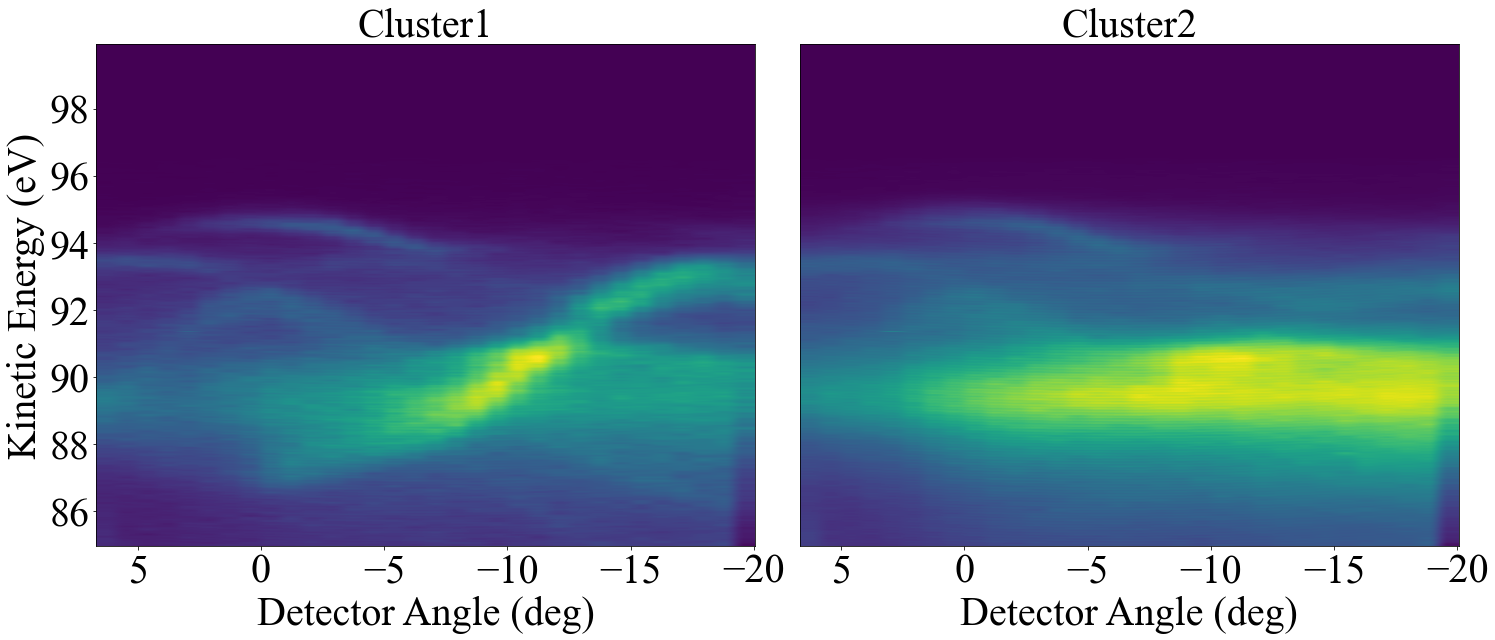

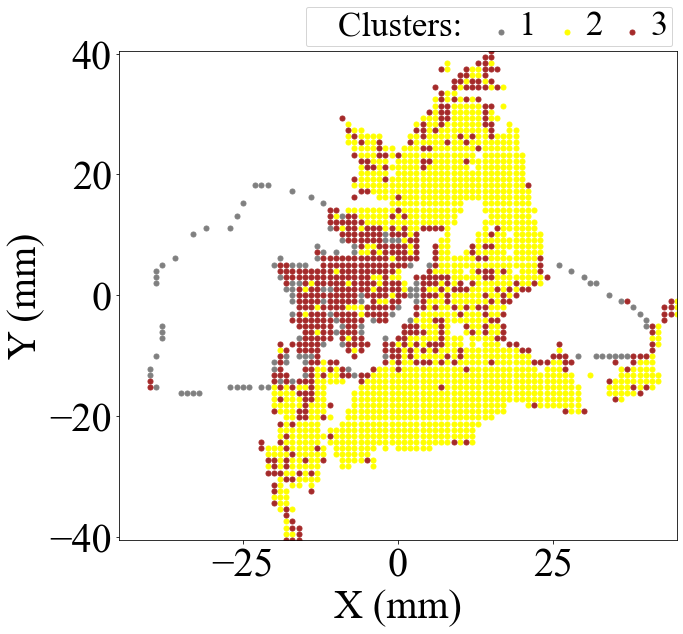

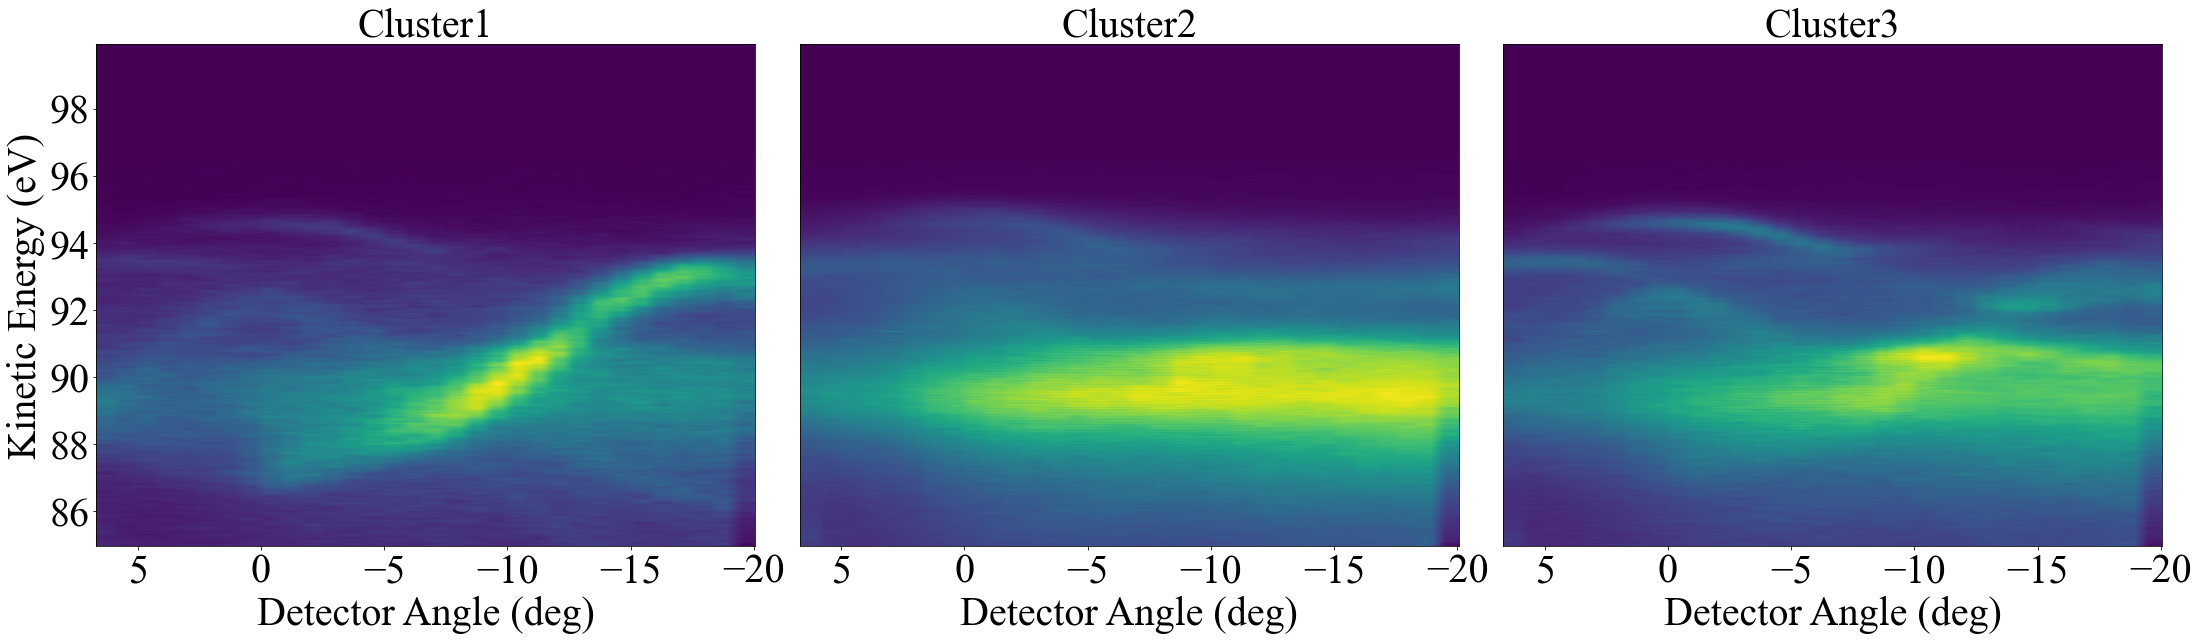

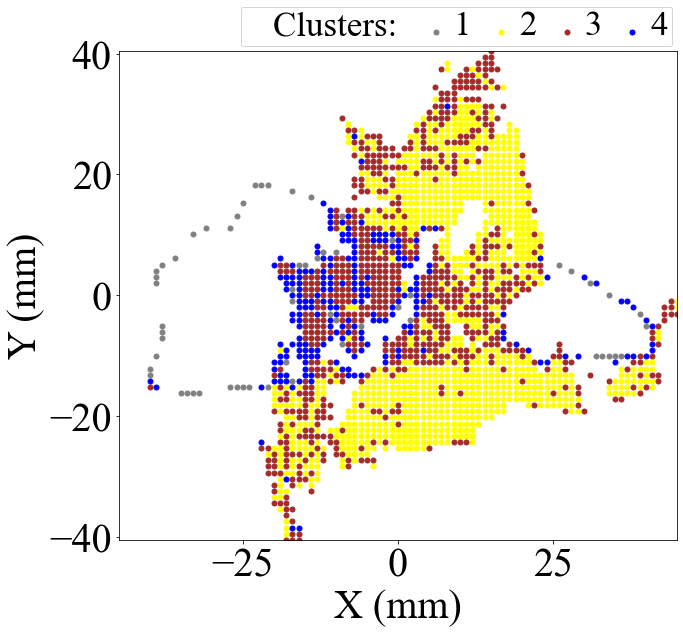

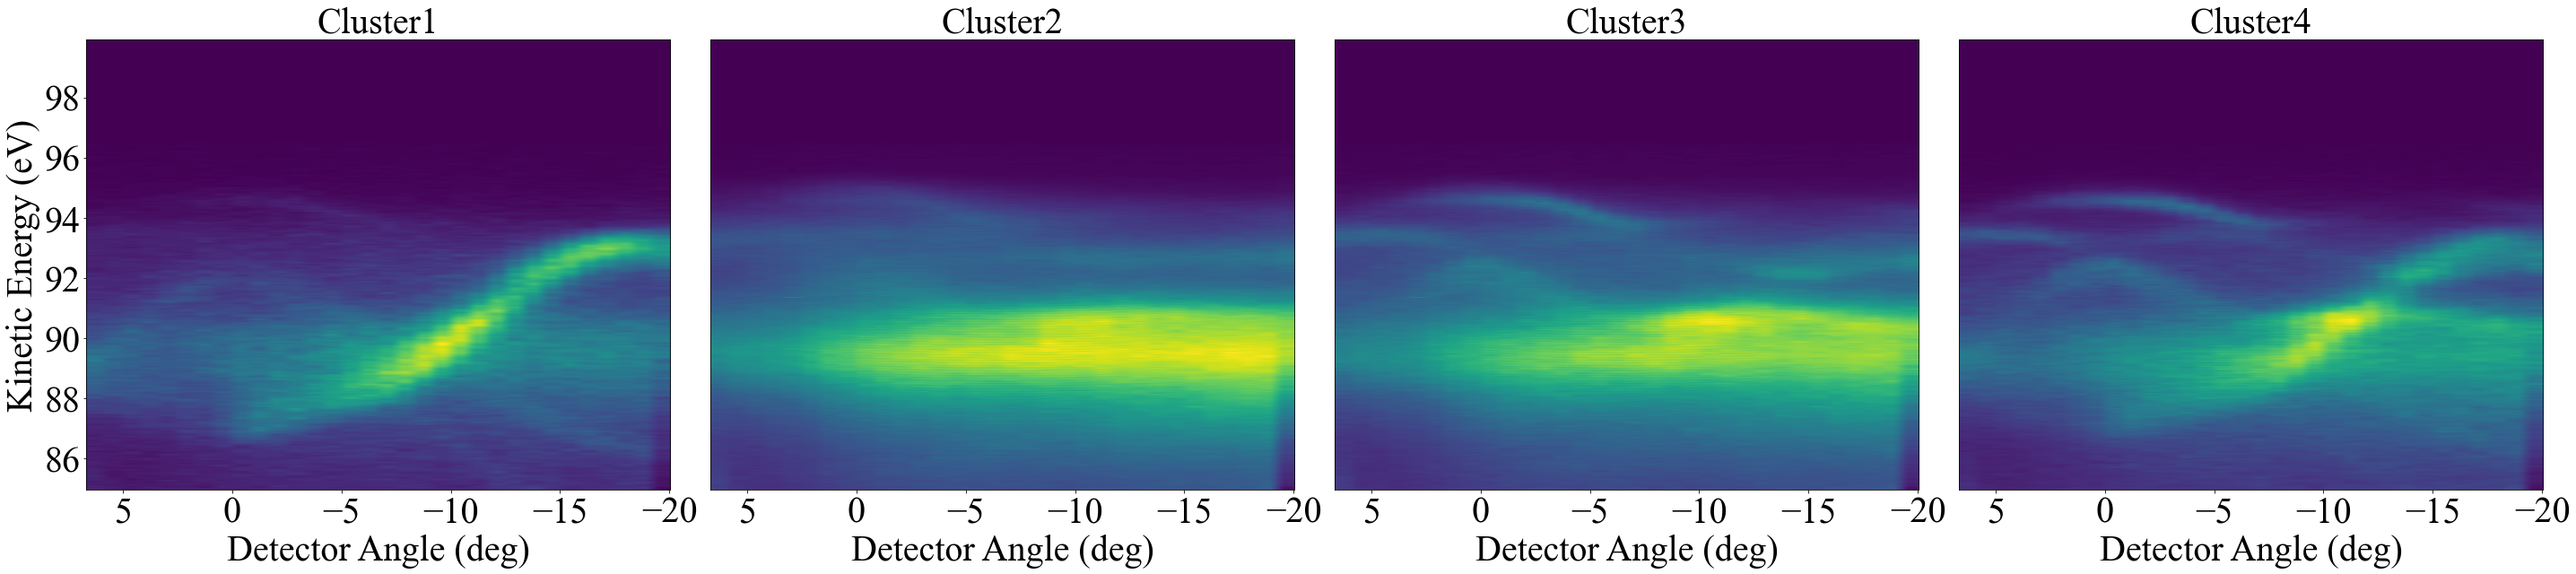

In [25]:
target = 1

iEDCs_of_target_cluster, iARPESs_of_target_cluster = get_iEDCs_of_one_field(clresult_cluster, target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_cluster,ang,eng)


fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs_of_target_cluster, extent = [engstart, engend, 1,iARPESs_of_target_cluster.shape[0]], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("iEDCs",fontsize=fontsize1)
plt.xticks(np.arange(engstart, engend+1,1))
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/iEDCs_3_right.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/iEDCs_3_right.png', dpi=300, bbox_inches='tight')


fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3_left.png', dpi=300, bbox_inches='tight')

fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3_right.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3_right.png', dpi=300, bbox_inches='tight')

nk = 2
result,fig = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping=None)
fig.savefig(f'{plotfolder}/plot_3-2_right.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-2_right.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-2_right.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-2_right.png', dpi=300)

nk = 3
result,fig = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping={0:2,2:0,1:1})
fig.savefig(f'{plotfolder}/plot_3-3_right.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-3_right.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-3_right.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-3_right.png', dpi=300)

nk = 4
result, fig= clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping={3:0,1:1,0:2,2:3})
fig.savefig(f'{plotfolder}/plot_3-4_right.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-4_right.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-4_right.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4_right.png', dpi=300)

### - Analyse the feature on the bottom right corner

In [26]:
def get_iEDCs_of_one_field(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_chosen,ang,eng):
    engleft, engright, angleft, angright = get_ranges_of_one_filed(clustering_result,target,angstart, angend,engstart, engend,angbin,engbin)
    iARPESs_of_one_field = get_iARPESs_of_one_field(engleft,engright,angleft,angright,iARPESs_chosen,ang,eng)
    
    #The range in angle direction is from -10deg to angend
    LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(-10,angend,engstart,engend,ang,eng)
    print(LR_col,RR_col,LR_row,RR_row)
    iARPESs_of_one_field = iARPESs_of_one_field[:,LR_row:RR_row+1,LR_col:RR_col+1]

    iEDCs_of_one_field = np.sum(iARPESs_of_one_field, axis = 2).reshape(iARPESs_of_one_field.shape[0],iARPESs_of_one_field.shape[1]) 

    
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(iEDCs_of_one_field, extent = [engstart, engend, 1,iARPESs_of_one_field.shape[0]], aspect = 0.0025)
    cbar = fig.colorbar(im)

    plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
    plt.ylabel('Data Points',fontsize=fontsize1)
    plt.title("iEDCs",fontsize=fontsize1)
    plt.xticks(fontsize=fontsize1)
    plt.yticks(fontsize=fontsize1)
    cbar.ax.tick_params(labelsize=fontsize2)
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.gcf()
    plt.show()
    
    return iEDCs_of_one_field,iARPESs_of_one_field

11 30 417 656


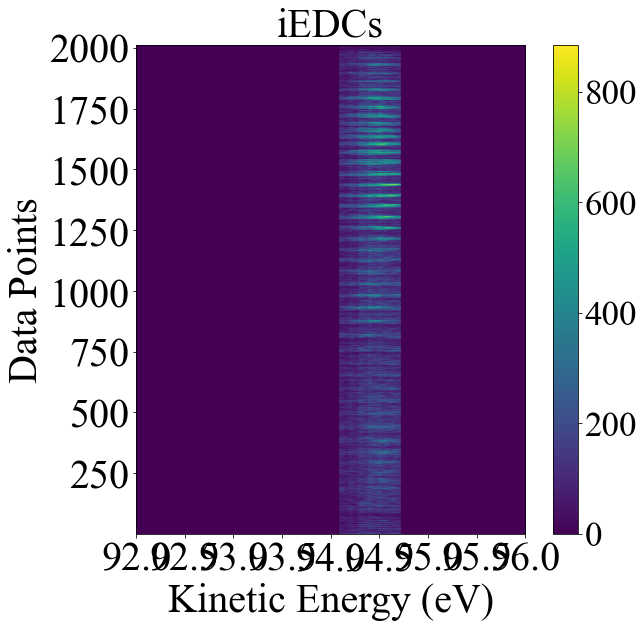

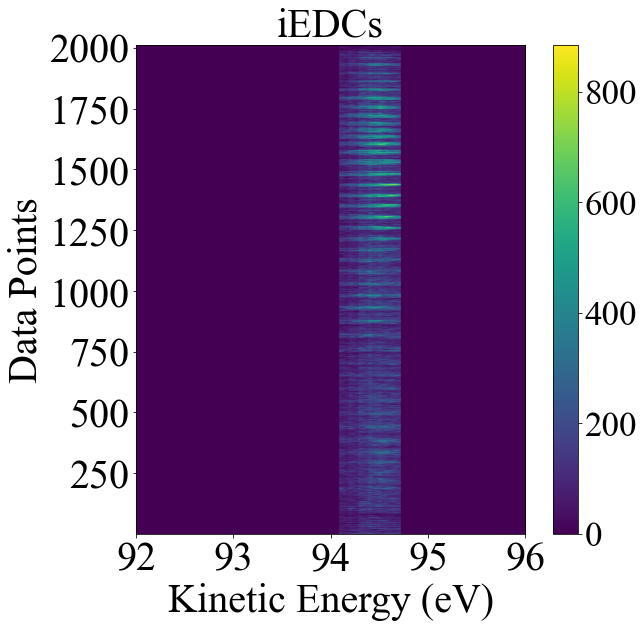

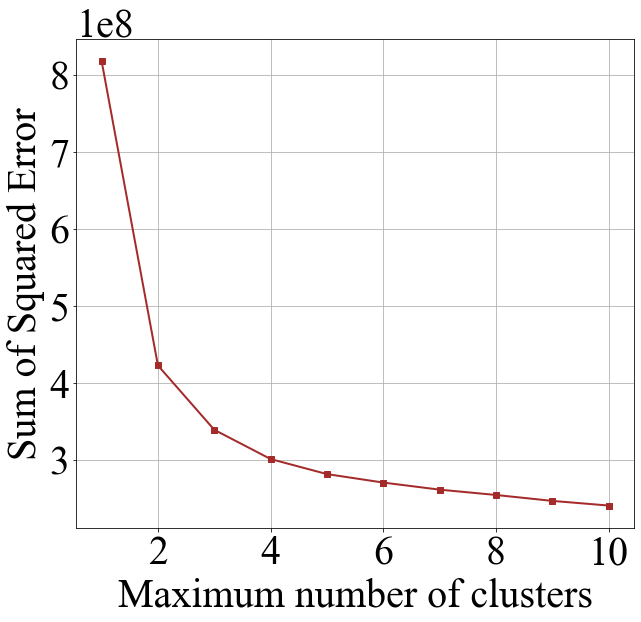

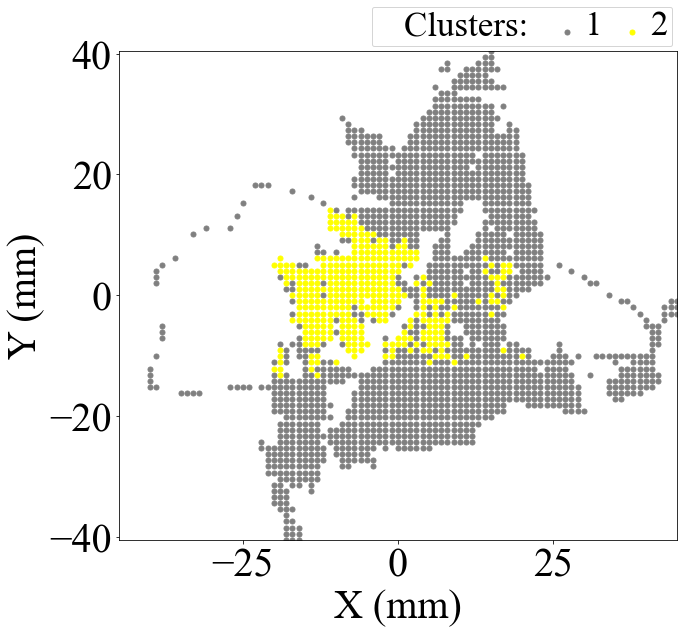

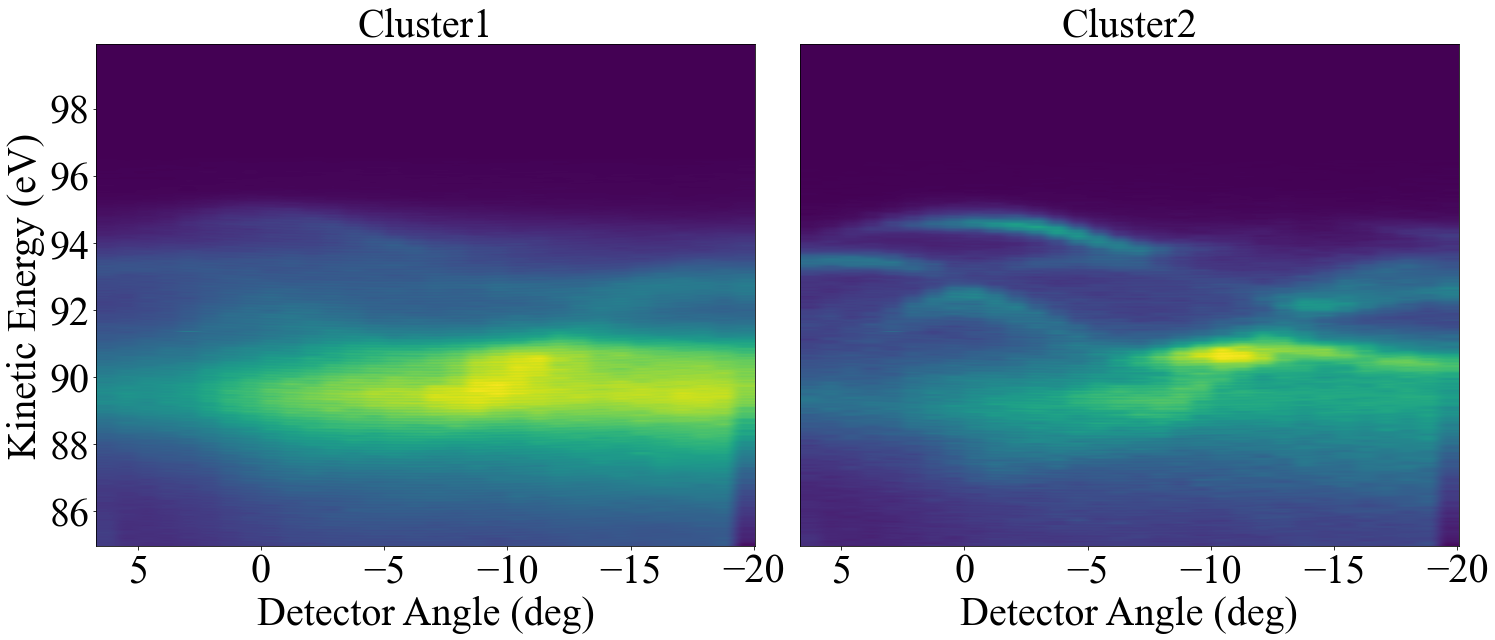

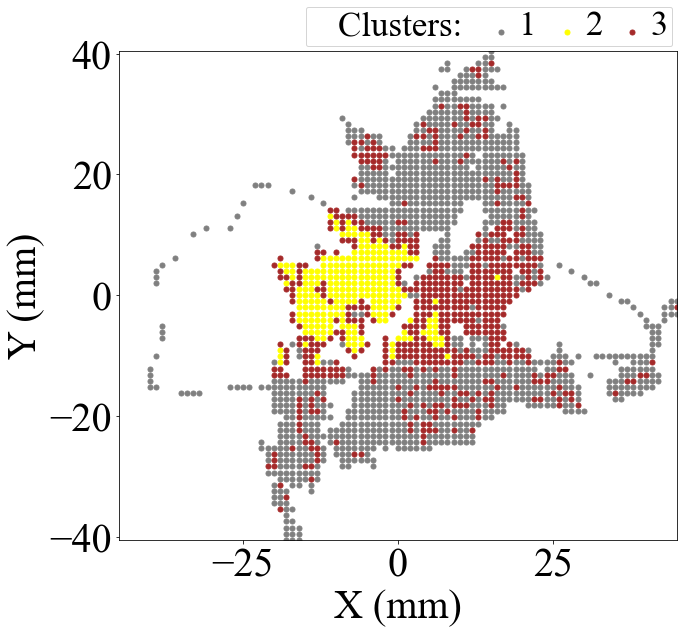

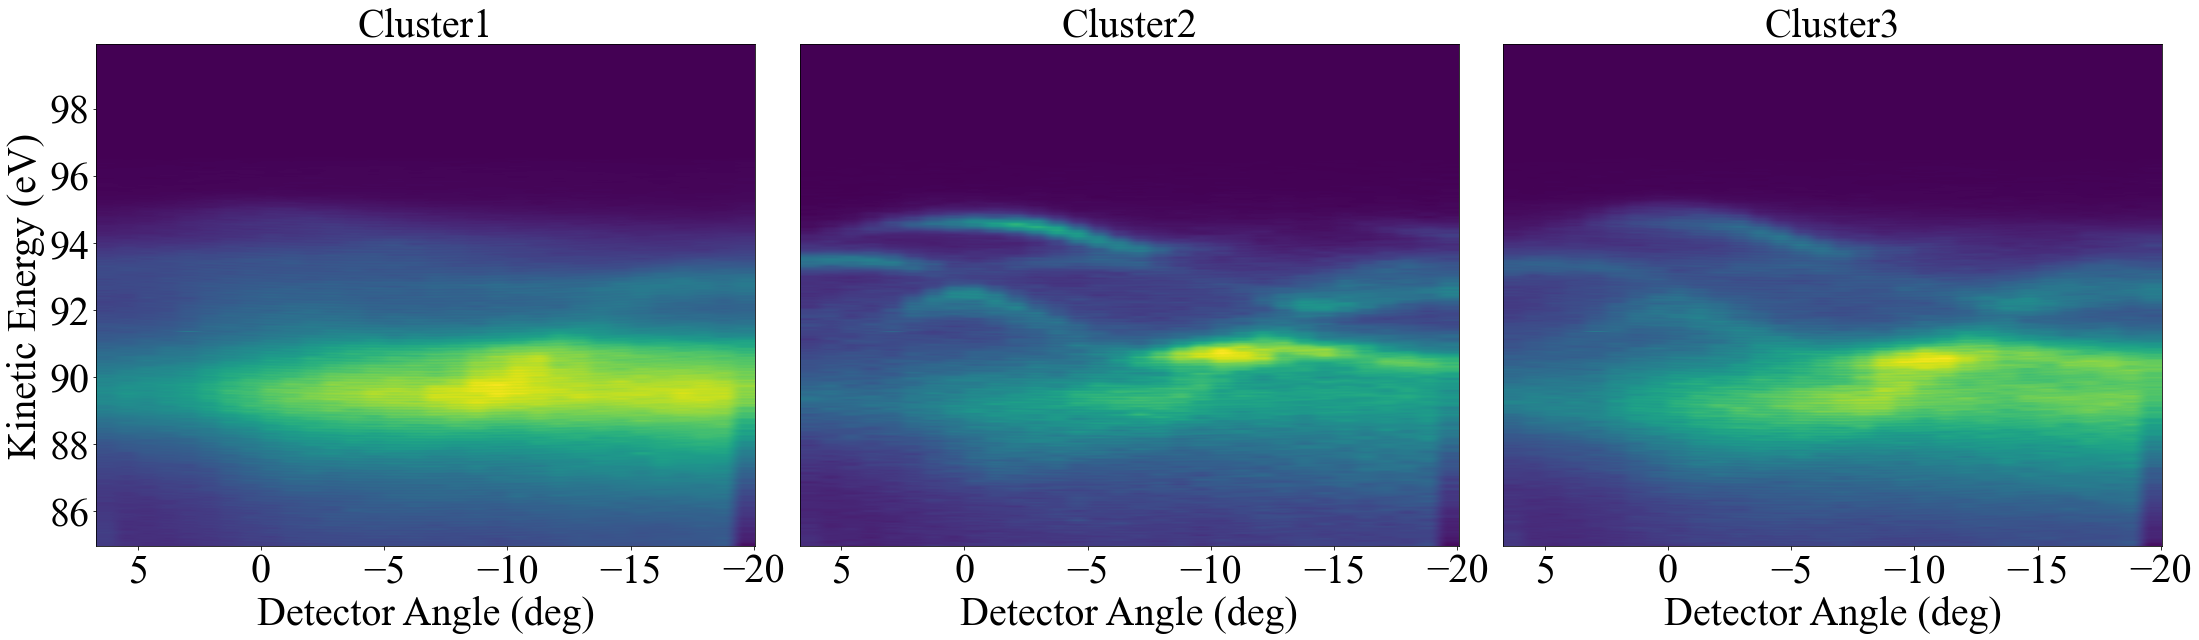

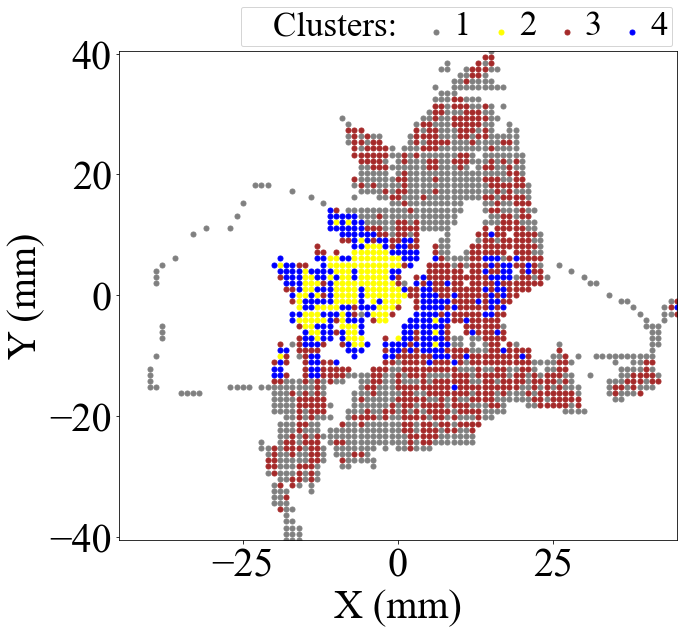

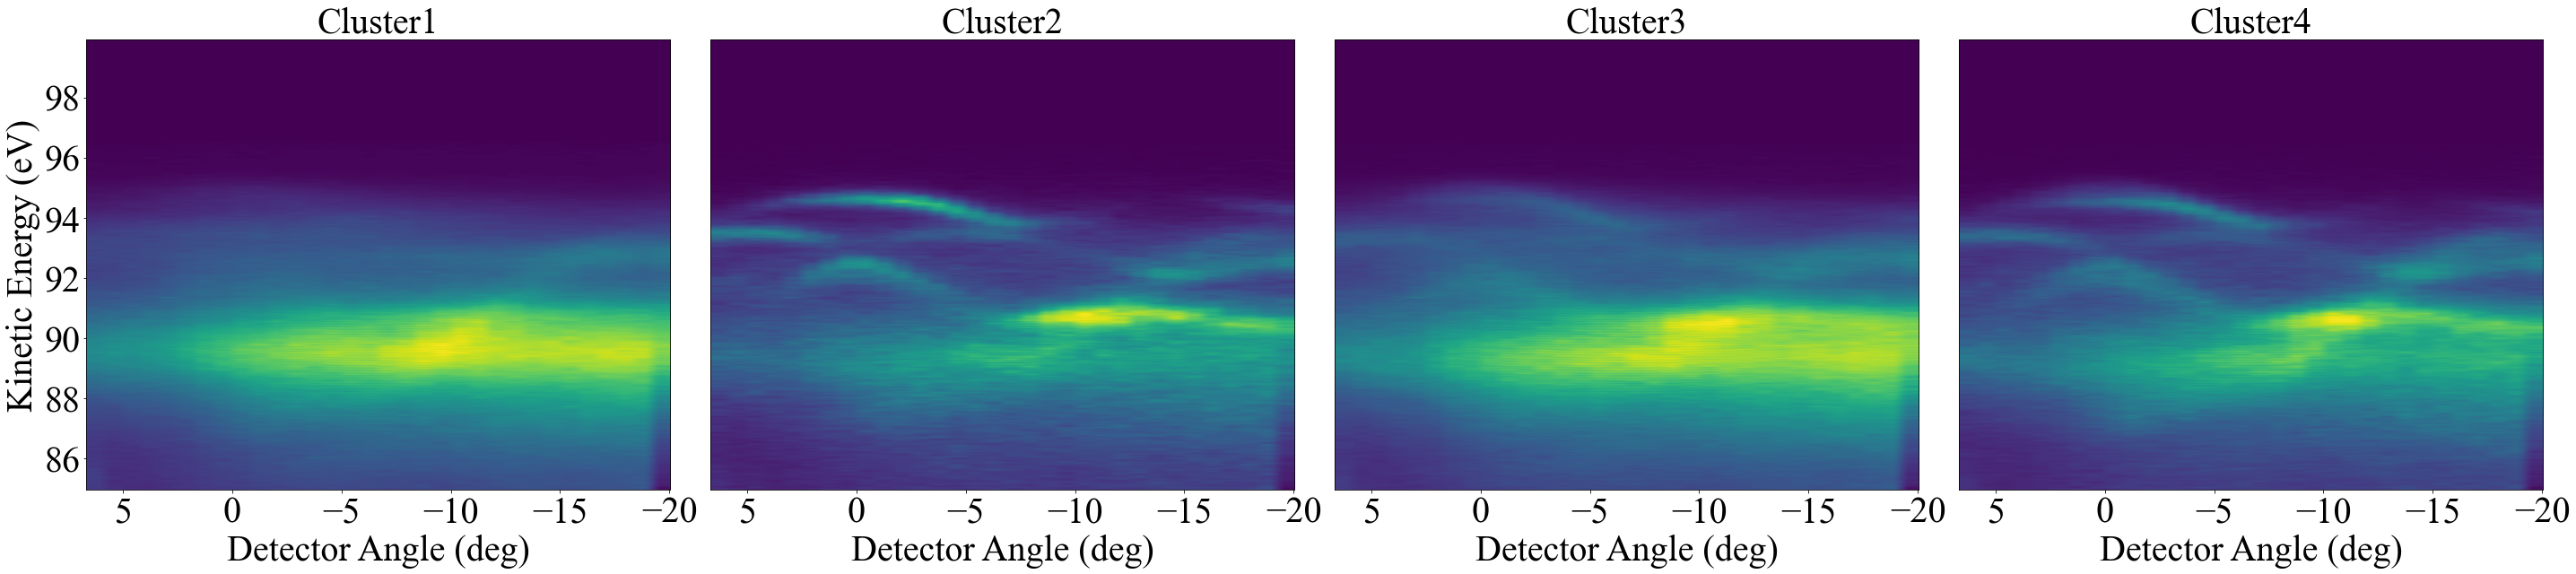

In [27]:
target = 1

iEDCs_of_target_cluster, iARPESs_of_target_cluster = get_iEDCs_of_one_field(clresult_cluster, target,angstart, angend,engstart, engend,angbin,engbin,iARPESs_cluster,ang,eng)
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs_of_target_cluster, extent = [engstart, engend, 1,iARPESs_of_target_cluster.shape[0]], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("iEDCs",fontsize=fontsize1)
plt.xticks(np.arange(engstart, engend+1,1))
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.gcf()
plt.show()
fig.savefig(f'{plotfolder}/iEDCs_3_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/iEDCs_3_left.png', dpi=300, bbox_inches='tight')


fig = get_sse_curve(max_nk,iEDCs_of_target_cluster)
fig.savefig(f'{plotfolder}/SSE_3_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/SSE_3_left.png', dpi=300, bbox_inches='tight')

nk = 2
result,fig = clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping=None)
fig.savefig(f'{plotfolder}/plot_3-2_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-2_left.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-2_left.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-2_left.png', dpi=300)

nk = 3
result, fig= clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping={2:0,1:1,0:2})
fig.savefig(f'{plotfolder}/plot_3-3_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-3_left.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-3_left.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-3_left.png', dpi=300)

nk = 4
result, fig= clustering_and_visualization(nk,iEDCs_of_target_cluster,x_cluster,y_cluster,label_mapping={3:0,0:1,2:2,1:3})
fig.savefig(f'{plotfolder}/plot_3-4_left.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'{plotfolder}/plot_3-4_left.png', dpi=300, bbox_inches='tight')
fig = iARPESs_cluster_visualization(nk,result,iARPESs_cluster,ang_ini,ang_end,eng_ini,eng_end)
fig.savefig(f'{plotfolder}/ARPES_3-4_left.pdf', dpi=300)
fig.savefig(f'{plotfolder}/ARPES_3-4_left.png', dpi=300)